In [1]:
#Imports packages
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import csv

In [2]:
#Sets constants
h = 6.62607015*10**(-34) #Planck's constant
c = 299792458 #Speed of light
kb = 1.380649*10**(-23) #Boltzmann constant

#Section 2.2: Simulations to Probe Important Emissivity Regions

This model simulates samples with a simple piecewise emissivity spectrum to find their equilibrium temperatures. For wavelengths between 0.2µm and 4µm, the emissivity is eps_s. For wavelengths between 8µm and 13µm, the emissivity is eps_t. These parameters are tunable. The program produces a csv and a heat map from these simulations. It can simulate samples being tested during the day or at night.

In [3]:
#Defines a function to find the equilibrium temperature of a sample with a piecewise emissivity
def temp_eq_finder(eps_s, eps_t, H, T, T_atm, I_sun, I_atm):
  i = 0
  while i == 0:
    #Calculates radiative cooling for this iteration (I_rad)
    I_rad_wavelengths = I_sun_wavelengths*10**(-6) #List of wavelengths used as x-values for trapezoidal integration
    bb_sample = 2*math.pi*2*h*c**2/((I_rad_wavelengths**5)*(math.e**(h*c/(I_rad_wavelengths*kb*T))-1)) #Calculates the blackbody radiation spectrum at sample temperature for a one-sided emitting surface
    eps_sample = eps_s*(np.where(I_rad_wavelengths < .2*10**(-6), 0, 1) - np.where(I_rad_wavelengths < 4*10**(-6), 0, 1)) + eps_t*(np.where(I_rad_wavelengths < 8*10**(-6), 0, 1) - np.where(I_rad_wavelengths < 13*10**(-6), 0, 1)) #Creates piecewise emissivity profile with eps_s in solar heating range and eps_t in atmospheric transparency range
    I_rad = np.trapz(y=bb_sample*eps_sample, x=I_rad_wavelengths, dx=1.0, axis=-1) #Radiative cooling power emitted per square meter

    #Calculates conductive and convective transfers for this iteration (I_con)
    I_con = H*(T_atm - T)

    #Calculates net heat transfer into the sample
    I_tot = I_sun - I_rad + I_atm + I_con

    #Performs iteration
    if abs(I_tot) > 10**(-10):
      T = T + I_tot/(2*H) #Iteration can be finicky. If the calculations diverge, decrease the size of this step. If they take too long, increase the size of the step.
    else:
      i = 1
  return(T)

In [4]:
#Performs a sweep of the parameters eps_s and eps_t, holding other values constant, and saving the data to a csv called em_sweep.csv
T = 300 #Sets the initial temperature of the sample (K)
T_atm = 300 #Sets the temperature of the air (K)
H = 6.9 #Sets the value of the heat transfer coefficient (W/m^2/K)
nter = 100 #Number of values to check between maximum and minimum of emissivity ranges
mode = "day" #Sets mode of simulation, "day" or "night"

#Calculates solar radiative intensity in relevant wavelength ranges (I_sun_s, I_sun_t)
if mode == "day":
  df1 = pd.read_excel('e490_00a_amo.xls') #Loads solar intensity spectrum from Excel sheet
  I_sun_wavelengths = df1.iloc[:, 0] #Solar spectrum x values (wavelengths)
  I_sun_spec = df1.iloc[:, 1] #Solar intensity spectrum y values (spectral intensities)
  I_sun_s = np.trapz(y=I_sun_spec[81:1522], x=I_sun_wavelengths[81:1522], dx=1.0, axis=-1) #Power absorbed from sun in eps_s region
  I_sun_t = np.trapz(y=I_sun_spec[1631:1675], x=I_sun_wavelengths[1631:1675], dx=1.0, axis=-1) #Power absorbed from sun in eps_t region

#Calculates atmospheric radiative intensity in relevant wavelength ranges (I_atm_s, I_atm_t)
df2 = pd.read_csv('Modtran Mid-latitudes default.csv') #Loads atmospheric emissivity spectrum from Excel sheet
I_atm_wave = df2.iloc[:, 0] #Atmospheric spectrum x values (wavelengths)
I_atm_emissivities = 1-df2.iloc[:, 1] #Atmospheric emissivity spectrum y values (emissivities)
I_atm_wavelengths = I_atm_wave*10**(-6) #Changes units from microns to meters
bb_atm = 2*math.pi*2*h*c**2/((I_atm_wavelengths**5)*(math.e**(h*c/(I_atm_wavelengths*kb*T_atm))-1)) #Calculates the blackbody radiation spectrum at atmospheric temperature for a one-sided emitting surface
I_atm_s = np.trapz(y=bb_atm[:1763]*I_atm_emissivities[:1763], x=I_atm_wavelengths[:1763], dx=1.0, axis=-1) #Power absorbed from atmosphere in eps_s region
I_atm_t = np.trapz(y=bb_atm[2362:3414]*I_atm_emissivities[2362:3414], x=I_atm_wavelengths[2362:3414], dx=1.0, axis=-1) #Power absorbed from atmosphere in eps_t region

#Calculates equilibrium temperatures by sweeping through many values of eps_s and eps_t
temp_eqs = [["eps_s","eps_t","Equilibrium Temperature Difference (T_eq - T_atm)"]]
for i in range(nter+1):
  eps_s = round(i/nter, 3)
  for j in range(nter+1):
    eps_t = round(j/nter, 3)
    if mode == "day":
      I_sun = eps_s*I_sun_s + eps_t*I_sun_t #Total solar intensity
    else:
      I_sun = 0
    I_atm = eps_s*I_atm_s + eps_t*I_atm_t #Total atmospheric intensity
    temp_eqs = temp_eqs + [[eps_s,eps_t,temp_eq_finder(eps_s, eps_t, H, T, T_atm, I_sun, I_atm)-T_atm]]

#Creates csv of temperatures
with open("em_sweep.csv","w+") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(temp_eqs)

<ipython-input-4-9b3cf851ab70>:13: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  I_sun_s = np.trapz(y=I_sun_spec[81:1522], x=I_sun_wavelengths[81:1522], dx=1.0, axis=-1) #Power absorbed from sun in eps_s region
<ipython-input-4-9b3cf851ab70>:14: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  I_sun_t = np.trapz(y=I_sun_spec[1631:1675], x=I_sun_wavelengths[1631:1675], dx=1.0, axis=-1) #Power absorbed from sun in eps_t region
<ipython-input-4-9b3cf851ab70>:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  I_atm_s = np.trapz(y=bb_atm[:1763]*I_atm_emissivities[:1763], x=I_atm_wavelengths[:1763], dx=1.0, axis=-1) #Power absorbed from atmosphere in eps_s region
<ipython-input-4-9b3cf851ab70>:23: DeprecationWarning: `trapz`

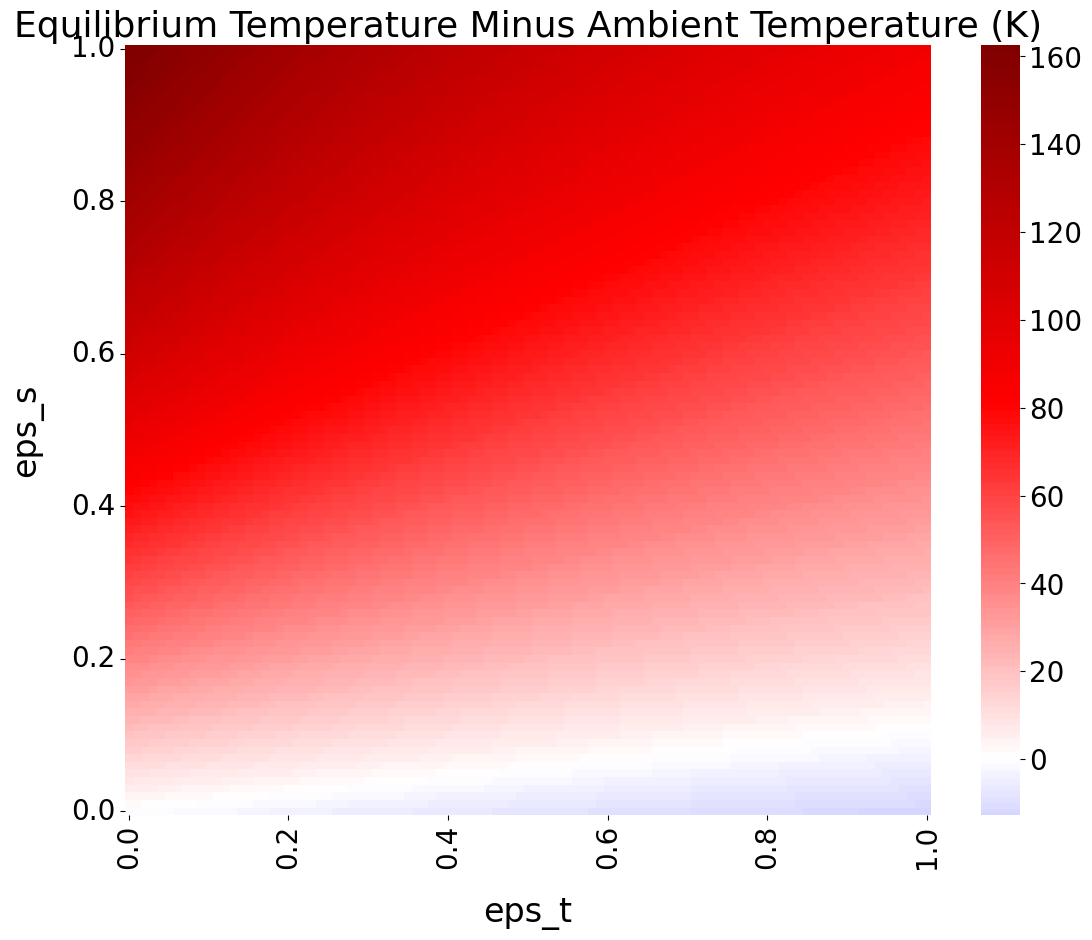

In [5]:
#Plots the data stored in em_sweep.csv as a heat map
df = pd.read_csv("em_sweep.csv") #Reads csv
result = df.pivot(index="eps_s", columns="eps_t", values="Equilibrium Temperature Difference (T_eq - T_atm)") #Creates the pivot table

fig, ax = plt.subplots(figsize=(13, 10)) #Defines the plot

#Title and Axis Labels
title = "Equilibrium Temperature Minus Ambient Temperature (K)" #Adds a title to the heat map
plt.title(title, fontsize=26) #Sets the font size
ttl = ax.title
ttl.set_position([0.5, 1.05]) #Sets the distance of the title from the plot
ax.set_xlabel("eps_s", labelpad=20, fontsize=24)  #Sets font size for x-axis title
ax.set_ylabel("eps_t", labelpad=20, fontsize=24)  #Sets font size for y-axis title

#Axis Numbers
ax.set_xticks([]) #Hides ticks for x & y axes
ax.set_yticks([])
ax.axis("on") #Includes the axes
plt.tick_params(axis="both", which="major", labelsize=20) #Sets the size of axis parameters for x and y ticks

#Heat map colors
heatmap = sns.heatmap(result, fmt="", cmap="seismic", center=0, linewidths=0, ax=ax) #Uses the heatmap function from the seaborn package
cbar = heatmap.collections[0].colorbar  #Accesses the color bar object
cbar.ax.tick_params(labelsize=20)  #Increases the font size for color bar ticks

#Filters out some ticks (optional)
x_ticks = plt.gca().get_xticks()  #Gets x-axis tick positions
y_ticks = plt.gca().get_yticks()  #Gets y-axis tick positions
x_ticks_included = [tick for tick in x_ticks if int(tick) % 20 == 0] #Filters out some ticks
y_ticks_included = [tick for tick in y_ticks if int(tick) % 20 == 0] #Filters out some ticks
plt.gca().set_xticks(x_ticks_included)
plt.gca().set_yticks(y_ticks_included)

#Invert y axis and display the plot
ax.invert_yaxis()

#Section 2.3: Simulations to Predict the Performance of Experimental and Control Samples at Night using FTIR Data

This model simulates experimental and control samples using FTIR data. It sweeps over the heat transfer coefficient parameter, H. The program produces a csv and two graphs from these simulations. It simulates samples being tested at night.

In [6]:
#Defines a function to find the equilibrium temperature of a sample with a given emissivity spectrum at night
def temp_eq_finder(T, T_atm, H, I_atm, eps):
  i = 0
  while i == 0:
    #Calculates radiative cooling for this iteration (I_rad)
    bb_sample = 2*math.pi*2*h*c**2/((I_rad_wavelengths**5)*(math.e**(h*c/(I_rad_wavelengths*kb*T))-1)) #Calculates the blackbody radiation spectrum at sample temperature for a one-sided emitting surface
    I_rad = np.trapz(y=bb_sample*eps, x=I_rad_wavelengths, dx=1.0, axis=-1) #Radiative cooling power emitted per square meter

    #Calculates conductive and convective transfers for this iteration (I_con)
    I_con = H*(T_atm - T)

    #Calculates net heat transfer into the sample
    I_tot = - I_rad + I_atm + I_con

    #Performs iteration
    if abs(I_tot) > 10**(-10):
      T = T + I_tot/(2*H) #Iteration can be finicky. If the calculations diverge, decrease the size of this step. If they take too long, increase the size of the step.
    else:
      i = 1
  return(T)


In [7]:
#Performs a sweep of the parameter H, holding other values constant, and saving the data to a csv called H_sweep.csv
T = 300 #Sets the initial temperature of the sample (K)
T_atm = 300 #Sets the temperature of the air (K)
H = 6.9 #Sets the value of the heat transfer coefficient (W/m^2/K)
low = .5 #Minimum value of H to test
hig = 500 #Maximum value of H to test
num = 9 #Number of values of H to test

#Calculates atmospheric radiative intensity in relevant wavelength ranges for each sample
df1 = pd.read_csv('AtmosphereAndFTIR.csv')
I_atm_wavelengths = df1.iloc[:, 0]/1000000 #Atmospheric spectrum x values (wavelengths)
I_atm_emissivities = 1-df1.iloc[:, 1] #Atmospheric spectrum y values (absorbance spectral intensities)
eps_atm_SEBSControl = df1.iloc[:, 2] #SEBS Control Sample Emissivity Spectrum
eps_atm_05um = df1.iloc[:, 3] #Half-micron sample emissivity
eps_atm_1um = df1.iloc[:, 4] #Micron sample emissivity
eps_atm_2um = df1.iloc[:, 5] #2-micron sample emissivity
eps_atm_4um = df1.iloc[:, 6] #4-micron sample emissivity
eps_atm_8um = df1.iloc[:, 7] #8-micron sample emissivity

bb_atm = 2*math.pi*2*h*c**2/((I_atm_wavelengths**5)*(math.e**(h*c/(I_atm_wavelengths*kb*T_atm))-1)) #Calculates the blackbody radiation spectrum at atmospheric temperature for a one-sided emitting surface
I_atm_spec = I_atm_emissivities*bb_atm #Actual atmospheric radiation
I_atm_SEBSControl = np.trapz(y=I_atm_spec*eps_atm_SEBSControl,x=I_atm_wavelengths) #Power absorbed by control sample from atmosphere
I_atm_05um = np.trapz(y=I_atm_spec*eps_atm_05um,x=I_atm_wavelengths) #Power absorbed by 0.5-micron sample from atmosphere
I_atm_1um = np.trapz(y=I_atm_spec*eps_atm_1um,x=I_atm_wavelengths) #Power absorbed by 1-micron sample from atmosphere
I_atm_2um = np.trapz(y=I_atm_spec*eps_atm_2um,x=I_atm_wavelengths) #Power absorbed by 2-micron sample from atmosphere
I_atm_4um = np.trapz(y=I_atm_spec*eps_atm_4um,x=I_atm_wavelengths) #Power absorbed by 4-micron sample from atmosphere
I_atm_8um = np.trapz(y=I_atm_spec*eps_atm_8um,x=I_atm_wavelengths) #Power absorbed by 8-micron sample from atmosphere

#Loads sample emissivities for calculating radiative cooling
df2 = pd.read_csv('RadiativeCoolingAndFTIR.csv')
I_rad_wavelengths = df2.iloc[:, 0]/1000000 #Emissivity spectrum x values (wavelengths)
eps_SEBSControl = df2.iloc[:, 1] #SEBS Control Sample Emissivity Spectrum
eps_05um = df2.iloc[:, 2] #Half-micron sample emissivity
eps_1um = df2.iloc[:, 3] #Micron sample emissivity
eps_2um = df2.iloc[:, 4] #2-micron sample emissivity
eps_4um = df2.iloc[:, 5] #4-micron sample emissivity
eps_8um = df2.iloc[:, 6] #8-micron sample emissivity

#Calculates equilibrium temperatures by sweeping through many values of H
temp_eqs = [["H","Control","05um","1um","2um","4um","8um"]]
for i in range(num+1):
  H = low*(hig/low)**(i/num)
  temp_eqs = temp_eqs + [[H,temp_eq_finder(T, T_atm, H, I_atm_SEBSControl, eps_SEBSControl)-T_atm,temp_eq_finder(T, T_atm, H, I_atm_05um, eps_05um)-T_atm,temp_eq_finder(T, T_atm, H, I_atm_1um, eps_1um)-T_atm,temp_eq_finder(T, T_atm, H, I_atm_2um, eps_2um)-T_atm,temp_eq_finder(T, T_atm, H, I_atm_4um, eps_4um)-T_atm,temp_eq_finder(T, T_atm, H, I_atm_8um, eps_8um)-T_atm]]

#Creates csv of temperatures
with open("H_sweep.csv","w+") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(temp_eqs)

<ipython-input-7-14ebfda098b2>:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  I_atm_SEBSControl = np.trapz(y=I_atm_spec*eps_atm_SEBSControl,x=I_atm_wavelengths) #Power absorbed by control sample from atmosphere
<ipython-input-7-14ebfda098b2>:23: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  I_atm_05um = np.trapz(y=I_atm_spec*eps_atm_05um,x=I_atm_wavelengths) #Power absorbed by 0.5-micron sample from atmosphere
<ipython-input-7-14ebfda098b2>:24: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  I_atm_1um = np.trapz(y=I_atm_spec*eps_atm_1um,x=I_atm_wavelengths) #Power absorbed by 1-micron sample from atmosphere
<ipython-input-7-14ebfda098b2>:25: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or on

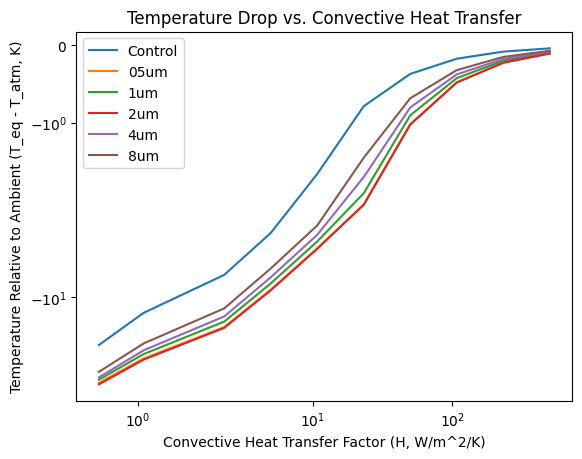

In [8]:
#Reads csv
df1 = pd.read_csv("H_sweep.csv")

#Plots findings
plt.plot(df1['H'], df1['Control'], label="Control")
plt.plot(df1['H'], df1['05um'], label="05um")
plt.plot(df1['H'], df1['1um'], label="1um")
plt.plot(df1['H'], df1['2um'], label="2um")
plt.plot(df1['H'], df1['4um'], label="4um")
plt.plot(df1['H'], df1['8um'], label="8um")
plt.xlabel('Convective Heat Transfer Factor (H, W/m^2/K)')
plt.xscale('symlog') #Sets the x axis to a symmetric log scale
plt.ylabel('Temperature Relative to Ambient (T_eq - T_atm, K)')
plt.yscale('symlog') #Sets the y axis to a symmetric log scale
plt.title('Temperature Drop vs. Convective Heat Transfer')
plt.legend()
plt.show()

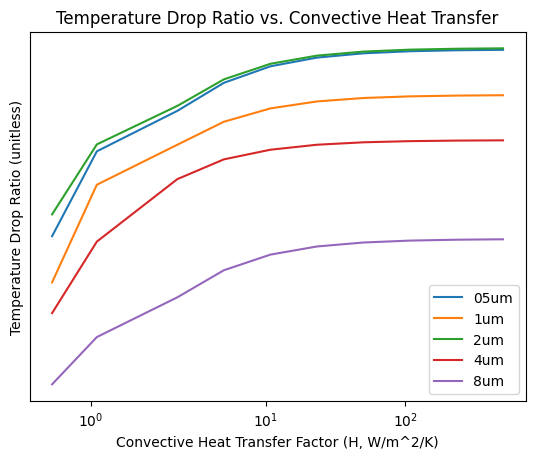

In [9]:
#Calculates and plots ratios of experimental to control samples

#Reads csv
df1 = pd.read_csv("H_sweep.csv")

#Plots findings
plt.plot(df1['H'], df1['05um']/df1['Control'], label="05um")
plt.plot(df1['H'], df1['1um']/df1['Control'], label="1um")
plt.plot(df1['H'], df1['2um']/df1['Control'], label="2um")
plt.plot(df1['H'], df1['4um']/df1['Control'], label="4um")
plt.plot(df1['H'], df1['8um']/df1['Control'], label="8um")
plt.xlabel('Convective Heat Transfer Factor (H, W/m^2/K)')
plt.xscale('symlog') #Sets the x axis to a symmetric log scale
plt.ylabel('Temperature Drop Ratio (unitless)')
plt.yscale('symlog') #Sets the y axis to a symmetric log scale
plt.title('Temperature Drop Ratio vs. Convective Heat Transfer')
plt.legend()
plt.show()